In [85]:
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer
import pandas as pd
import numpy as np
import spacy
import sklearn
import pymorphy2
from pymorphy2 import MorphAnalyzer
import string
import re
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import matplotlib_inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [87]:
import torch
import transformers as ppb

import warnings
warnings.filterwarnings('ignore')

In [88]:
nltk.download('stopwords')
nltk.download('punkt')
rus = "russian"
sw = stopwords.words(rus)
morph = MorphAnalyzer()
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
lancaster = LancasterStemmer()
snowball = SnowballStemmer(language=rus)
vectorizer = CountVectorizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NitghtWay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NitghtWay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [89]:
#ф-я для вывода текстовых данных в удобном формате
def print_table(array):
    table_width = 5
    for i in range(0, len(array), table_width):
        row = array[i:i + table_width]
        formatted_row = " ".join(["{:<10}".format(str(elem)) for elem in row])
        print(formatted_row)
#ф-я для удаления символов пунктуации
def remove_punctuation(text):
    return ''.join([ch for ch in text if ch not in 
    string.punctuation])
#ф-я для удаления чисел
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text]) 
#ф-я для удаления последовательностей
def remove_patterns(text):
    text = re.sub(patterns, ' ', text)
    return text
#ф-я для удаления не буквенных символов
def remove_notalpha(text):
    return ''.join(i if i.isalpha() else ' ' for i in text)

In [90]:
#ф-я токенизации с использованием Snowball
def tokenize_snowball(text):
    text = remove_notalpha(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_patterns(text)
    sentences = sent_tokenize(text, language=rus)
    all_words = []
    for sent in sentences:
        words = word_tokenize(sent, language=rus)
        for w in words:
            if w in sw or len(w) >= 11:
                continue
            else:
                all_words.append(snowball.stem(w))
            
    return ' '.join(all_words)

In [91]:
#ф-я токенизации с использованием Lancaster
def tokenize_lancaster(text):
    text = remove_notalpha(text)
    text = remove_numbers(text)
    text = remove_patterns(text)
    text = remove_punctuation(text)
    sentences = sent_tokenize(text, language=rus)
    all_words = []
    for sent in sentences:
        words = word_tokenize(sent, language=rus)
        for w in words:
            if w in sw or len(w) >= 11:
                continue
            else:
                all_words.append(lancaster.stem(w))
    return ' '.join(all_words)

In [92]:
#ф-я токенизации с помощью PyMorphy2
def tokenize_morphy(text):
    text = remove_notalpha(text)
    text = remove_patterns(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    sentences = sent_tokenize(text, language=rus)
    all_words = []
    for sent in sentences:
        words = word_tokenize(sent, language=rus)
        for w in words:
            all_words.append(morph.normal_forms(w)[0])
    if len(all_words) > 2:
        return ' '.join(all_words)
    else:
        return None
    

In [93]:
train_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\train.jsonl'
val_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\val.jsonl'
train_data = pd.read_json(train_path, lines=True)
val_data = pd.read_json(val_path, lines=True)
df = pd.concat([train_data, val_data])

In [94]:
df.shape

(1096, 8)

In [95]:
df.head()

,premise,label,hypothesis,verb,negation,genre,idx,no_negation
0,Сумма ущерба составила одну тысячу рублей. Уто...,entailment,Ранее местный житель совершал подобное правона...,судить,no_negation,kp,0,NaN
1,"Перебрасываясь словечками, они скользят глазам...",contradiction,Они что-то понимают,смотреть,no_negation,fiction,1,NaN
2,"— Разве что, — сказала она, — мы хотим где-ниб...",neutral,"Это “ Таганская ”, а не “ Тульская ”.",понять,no_negation,fiction,2,NaN
3,"Зима, наконец, показала свой характер.",contradiction,У зимы есть свой характер.,показать,no_negation,kp,3,NaN
4,Гуманность Бога подобным сценарием не предпола...,contradiction,Это должно быть просто.,сказать,no_negation,fiction,4,NaN


In [96]:
df = df.drop(['label', 'hypothesis', 'verb','negation'
,'idx','no_negation'], axis=1)

In [97]:
df.dropna()

,premise,genre
0,Сумма ущерба составила одну тысячу рублей. Уто...,kp
1,"Перебрасываясь словечками, они скользят глазам...",fiction
2,"— Разве что, — сказала она, — мы хотим где-ниб...",fiction
3,"Зима, наконец, показала свой характер.",kp
4,Гуманность Бога подобным сценарием не предпола...,fiction
...,...,...
215,Кому они нужны? Ее нужно забрать в сумасшедший...,fiction
216,"– А я вас все равно люблю, – скажу я. – Но как...",fiction
217,"По ее словам, она помнит лишь, что собиралась ...",kp
218,"Допросив гостя, следователи восстановили карти...",kp


In [98]:
df.head()

,premise,genre
0,Сумма ущерба составила одну тысячу рублей. Уто...,kp
1,"Перебрасываясь словечками, они скользят глазам...",fiction
2,"— Разве что, — сказала она, — мы хотим где-ниб...",fiction
3,"Зима, наконец, показала свой характер.",kp
4,Гуманность Бога подобным сценарием не предпола...,fiction


In [99]:
df['genre'] = df['genre'].replace('kp', 'interfax')

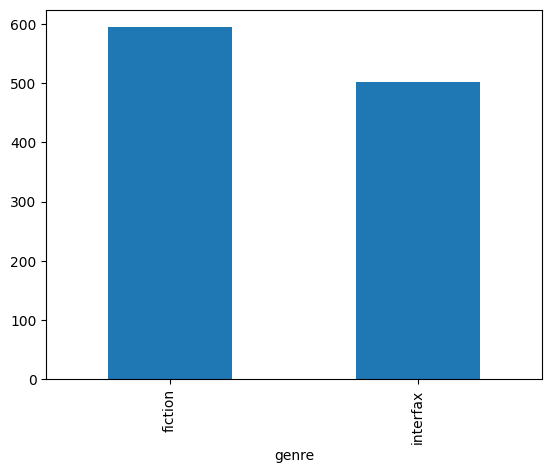

In [100]:
pivot_table = df.groupby('genre').size()
pivot_table.plot(kind='bar')
plt.show()

In [101]:
Y = pd.DataFrame({'genre':[str(genre) for genre in df['genre']]})
#Формирование наборов данных
df_morphy = pd.DataFrame({'text':[tokenize_morphy(sample) 
for sample in df['premise']]})
df_snowball = pd.DataFrame({'text':[tokenize_snowball(sample) 
for sample in df['premise']]})
df_lancaster = pd.DataFrame({'text':[tokenize_lancaster(sample) 
for sample in df['premise']]})
#Очистка от пустот
X1 = df_lancaster.dropna()
X2 = df_morphy.dropna()
X3 = df_snowball.dropna()

In [102]:
Y.head()

,genre
0,interfax
1,fiction
2,fiction
3,interfax
4,fiction


In [103]:
X = X2
print(X.shape)
print(Y.shape)
x_train, x_test, y_train, y_test = train_test_split(X.text, Y.genre, test_size = 0.1, random_state = 45)

(1096, 1)
(1096, 1)


In [104]:
#BOW
vec = CountVectorizer(ngram_range=(1, 1))

bow = vec.fit_transform(x_train)  # bow — bag of words (мешок слов)
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     fiction       0.95      0.88      0.91        64
    interfax       0.84      0.93      0.89        46

    accuracy                           0.90       110
   macro avg       0.90      0.90      0.90       110
weighted avg       0.90      0.90      0.90       110



In [105]:
#Tf-idf
vec = TfidfVectorizer(ngram_range=(1, 1))
vec_train = vec.fit_transform(x_train)
vec_test = vec.transform(x_test)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print(classification_report(y_test, pred_tfidf))

              precision    recall  f1-score   support

     fiction       0.93      0.89      0.91        64
    interfax       0.86      0.91      0.88        46

    accuracy                           0.90       110
   macro avg       0.90      0.90      0.90       110
weighted avg       0.90      0.90      0.90       110



In [106]:
reverse_vocab = {value: key for key, value in vec.vocabulary_.items()}
reverse_vocab[np.argmax(clf.coef_)]

'подозревать'

Анализ посимвольный

In [107]:
train_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\train.jsonl'
val_path = 'C:\\course_work\\feature_extraction_NLP\\data\\test_ds1\\val.jsonl'
train_data = pd.read_json(train_path, lines=True)
val_data = pd.read_json(val_path, lines=True)
df = pd.concat([train_data, val_data])
df = df.drop(['label', 'hypothesis', 'verb','negation'
,'idx','no_negation'], axis=1)
df['genre'] = df['genre'].replace('kp', 'interfax')

In [108]:
Y = pd.DataFrame({'genre':[str(genre) for genre in df['genre']]})
X = pd.DataFrame({'text': [text for text in df['premise']]})
x_train, x_test, y_train, y_test = train_test_split(X.text, Y.genre, random_state = 13)

In [131]:
x_train.head()

600    и человек вроде бы хороший мягкий артист немно...
76     каждый сам за себя жить вместе а с ум сходить ...
591    по он слово по мера укрепление партийный струк...
321    после стать я думать что говорить мама когда о...
487    за умышленный причинение тяжкий вред здоровье ...
Name: text, dtype: object

In [109]:
vec = CountVectorizer(ngram_range=(1, 1), analyzer="char")
bow = vec.fit_transform(x_train)
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     fiction       0.87      0.91      0.89       137
    interfax       0.91      0.86      0.88       137

    accuracy                           0.89       274
   macro avg       0.89      0.89      0.89       274
weighted avg       0.89      0.89      0.89       274



In [110]:
reverse_vocab = {value: key for key, value in vec.vocabulary_.items()}
reverse_vocab[np.argmax(clf.coef_)]

'"'

Использование BERT, W2V, улучшение мешка слов и tf-idf

In [111]:
X = X2 
x_train, x_test, y_train, y_test = train_test_split(X.text, Y.genre, test_size = 0.2, random_state = 45)
print(x_train.shape)
print(x_test.shape)

(876,)
(220,)


In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 5, max_df = 1.0, ngram_range = (1, 1))
tfidf.fit(x_train)

TfidfVectorizer(min_df=5)

In [113]:
Xtrain = tfidf.transform(x_train)
Xtest = tfidf.transform(x_test)

Xtrain.shape, Xtest.shape

((876, 679), (220, 679))

In [114]:
lr_clf = LogisticRegression()
lr_clf.fit(Xtrain, y_train)

lr_train_pred = lr_clf.predict(Xtrain)
lr_test_pred = lr_clf.predict(Xtest)

In [115]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, lr_train_pred), accuracy_score(y_test, lr_test_pred)

(0.9257990867579908, 0.8818181818181818)

N-граммы

In [116]:
tfidf = TfidfVectorizer(min_df=5, max_df=1.0, ngram_range=(1, 2))
tfidf.fit(x_train)

TfidfVectorizer(min_df=5, ngram_range=(1, 2))

In [117]:
Xtrain = tfidf.transform(x_train)
Xtest = tfidf.transform(x_test)

Xtrain.shape, Xtest.shape

((876, 911), (220, 911))

In [118]:
lr_clf = LogisticRegression()
lr_clf.fit(Xtrain, y_train)

lr_train_pred = lr_clf.predict(Xtrain)
lr_test_pred = lr_clf.predict(Xtest)

accuracy_score(y_train, lr_train_pred), accuracy_score(y_test, lr_test_pred)

(0.932648401826484, 0.8863636363636364)

Word2vec

In [127]:
X = X2 #использование 
X_train, X_test, y_train, y_test = train_test_split(X.text, Y.genre, test_size = 0.3, random_state = 45)
print(X_train.shape, type(X_train))
print(X_test.shape, type(X_test))

(767,) <class 'pandas.core.series.Series'>
(329,) <class 'pandas.core.series.Series'>


In [128]:
X_test.head()

281     я посыпать голова пепел жениться хоть на стару...
63      мы по прежний исходить из тот что быть факт на...
5       для мама праздник быть как обычный день она ко...
256     снова появиться но уже с пепельница мочь челов...
1054    сосед по камера жестоко избить мигрант в ход н...
Name: text, dtype: object

In [121]:
from gensim.models import Word2Vec
#X_train[91]
sent = [row.split() for row in X_train['text']]
print(sent)

KeyError: 'text'

In [ ]:
HIDDEN = 100
model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=HIDDEN,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=2)
model.build_vocab(sent, progress_per=10000)
model.train(sent, total_examples=model.corpus_count, epochs=30, report_delay=1)

(27078, 625650)

In [ ]:
#счет последнего вектора текста
def get_mean_w2v_vector(sentence):
    Sum = 0
    Count = 0

    try:
      words = sentence.split()
    except TypeError:
      words = []

    for w in words:
        if w in model.wv:
            Sum += model.wv[w]
            # Sum += glove_vectors[w]
            Count += 1

    if Count == 0:
        return 0

    return Sum / Count

In [ ]:
NewCols = ['col'+str(i) for i in range(HIDDEN)]

X_train['vectors'] = X_train['text'].map(get_mean_w2v_vector)
X_test['vectors'] = X_test['text'].map(get_mean_w2v_vector)

X_train.head()

In [ ]:
IdxTrain = []

for ix, row in X_train.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTrain.append(ix)

IdxTest = []

for ix, row in X_test.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTest.append(ix)

AttributeError: 'Series' object has no attribute 'iterrows'

In [ ]:
X_train.drop(index=IdxTrain, inplace=True)
X_test.drop(index=IdxTest, inplace=True)

y_train = y_train.drop(index=IdxTrain)
y_test = y_test.drop(index=IdxTest)

In [ ]:
X_train[NewCols] = pd.DataFrame(X_train['vectors'].tolist(), index=X_train.index)
X_test[NewCols] = pd.DataFrame(X_test['vectors'].tolist(), index=X_test.index)

In [ ]:
X_train.head()

In [ ]:
X_train.drop([0,'vectors'], axis=1, inplace=True)
X_test.drop([0,'vectors'], axis=1, inplace=True)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_train_pred = lr_clf.predict(X_train)
lr_test_pred = lr_clf.predict(X_test)

accuracy_score(y_train, lr_train_pred), accuracy_score(y_test, lr_test_pred)